In [1]:
# Library imports
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

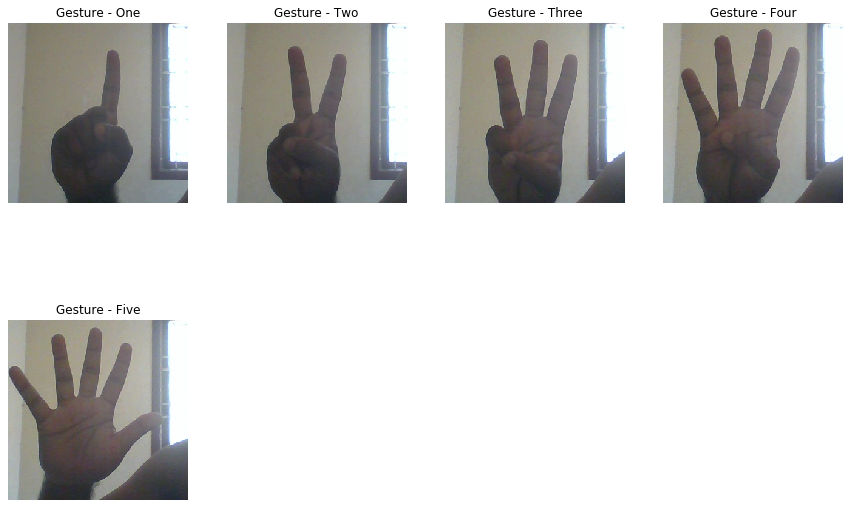

In [2]:

img1 = Image.open('data/one/one_100.jpg')
img2 = Image.open('data/two/two_100_TR.jpg')
img3 = Image.open('data/three/three_100_TR.jpg')
img4 = Image.open('data/four/four_100_TR.jpg')
img5 = Image.open('data/five/five_100_TR.jpg')



fig = plt.figure(figsize=(15, 10))

plt.subplot(241)
plt.imshow(img1)
plt.axis('off')
plt.title(f'Gesture - One')

plt.subplot(242)
plt.imshow(img2)
plt.axis('off')
plt.title(f'Gesture - Two')

plt.subplot(243)
plt.imshow(img3)
plt.axis('off')
plt.title(f'Gesture - Three')

plt.subplot(244)
plt.imshow(img4)
plt.axis('off')
plt.title(f'Gesture - Four')

plt.subplot(245)
plt.imshow(img5)
plt.axis('off')
plt.title(f'Gesture - Five')



plt.show()

In [3]:
class_dict = {
   
    'one' : 1,
    'two' : 2,
    'three' : 3, 
    'four' : 4,
    'five' : 5,
   
}
class_map = {
   
    1 : 'one',
    2 : 'two',
    3 : 'three',
    4 : 'four',
    5 : 'five',
   
}

In [4]:
class HandGestureDataset(torch.utils.data.dataset.Dataset):
   
    def __init__(self, data_path, train = True, transform = None):
        
        self.data_path = data_path
        self.train = train
        self.data, self.targets = self.load(self.data_path, train)
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = Image.open(self.data[idx])
        
        if self.transform:
            image = self.transform(image)
            
        return image, self.targets[idx]
        
    def load(self, data_path, train):
        images = []
        targets = []
        for class_name in os.listdir(data_path):
            target = class_dict[class_name]
            curr_path = os.path.join(data_path, class_name)
            for image_name in os.listdir(curr_path):
                if 'TR' in image_name and train:
                    images.append(os.path.join(curr_path, image_name))
                    targets.append(target)
                elif 'TE' in image_name and not train:
                    images.append(os.path.join(curr_path, image_name))
                    targets.append(target)
        
        indices = np.random.permutation(len(images))
        images = np.array(images)[indices]
        targets = np.array(targets, dtype=np.int64)[indices]
        return images, targets
    

In [5]:
def get_accuracy(output, target):
    predictions = torch.argmax(output.data, 1)
    accuracy = (predictions == target).sum().item() / target.size(0)
    return accuracy

def validate(model, device, loader, loss_criterion):
    model.eval()
    losses = []
    accuracies = []
    for idx, (image, target) in enumerate(loader):
        
        image, target = image.to(device), target.to(device)
        
        out = model(image)
        
        loss = loss_criterion(out, target)
        losses.append(loss.item())
        
        accuracy = get_accuracy(out, target)
        accuracies.append(accuracy)
    
    return np.mean(losses), np.mean(accuracies)

def execute_trainstep(model, device, loader, loss_criterion, optimizer):
    model.train()
    losses = []
    accuracies = []
    for idx, (image, target) in enumerate(loader):
        
        image, target = image.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        out = model(image)
        loss = loss_criterion(out, target)
        losses.append(loss.item())
        
        accuracy = get_accuracy(out, target)
        accuracies.append(accuracy)
        
        loss.backward()
        optimizer.step()
        
    return np.mean(losses), np.mean(accuracies)

def train(epochs, model, device, train_loader, valid_loader, loss_criterion, optimizer):
    train_losses = []
    valid_losses = []
    
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(1, epochs+1):
        
        start = time.time()
        
        train_loss, train_accuracy = execute_trainstep(model, device, train_loader, loss_criterion, optimizer)
        valid_loss, valid_accuracy = validate(model, device, valid_loader, loss_criterion)
        
        end = time.time()
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f"""\nEpoch {epoch}/{epochs} Time : {end-start:.2f}s 
                Training Loss : {train_losses[-1]:.6f} Validation Loss : {valid_losses[-1]:.6f}
                Training Accuracy : {train_accuracies[-1]*100:.2f} Validation Accuracy : {valid_accuracies[-1]*100:.2f}""")
        
    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.features = nn.Sequential(
                                nn.Conv2d(3, 6, 3),
                                nn.BatchNorm2d(6, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                nn.Conv2d(6, 12, 3),
                                nn.BatchNorm2d(12, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                nn.Conv2d(12, 24, 3),
                                nn.BatchNorm2d(24, affine = False),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(24, 48, 3),
                                nn.BatchNorm2d(48, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                nn.Conv2d(48, 96, 3),
                                nn.BatchNorm2d(96, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
        )
        self.classifier = nn.Sequential(
                                nn.Linear(96*4*4,1000),
                                nn.Tanh(),
                                nn.Dropout(p=0.4),
                                nn.Linear(1000, 8),
                                nn.Tanh()
        )
                                
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 96*4*4)
        x = self.classifier(x)
        return x

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

torch.cuda.empty_cache()

net = Net().to(device)


lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

cpu


In [8]:
transformer = transforms.Compose([
                                transforms.Resize((128, 128)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                            ])

train_dataset= HandGestureDataset(data_path='data', train=True, transform= transformer)
test_dataset = HandGestureDataset(data_path='data', train=False, transform= transformer)

test_sample=3.24
random_state=0.3
batch_size = 32
train_loader = torch.utils.data.dataloader.DataLoader(train_dataset, batch_size= batch_size)
test_loader = torch.utils.data.dataloader.DataLoader(test_dataset, batch_size= batch_size)

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from model_utils.model_activation import *
ac=[]
X,y=load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
def pixel_counting(img):
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray_img1=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    hist=cv2.calcHist(gray_img,[0],None,[256],[0,256])
    hist1=cv2.calcHist(gray_img1,[0],None,[256],[0,256])
    y_pred=clf.predict(X_test)
    plt.subplot(121)
    plt.title("Image1")
    plt.xlabel('bins')
    plt.ylabel("No of pixels")
    plt.plot(hist)
    plt.subplot(122)
    plt.title("Image2")
    plt.xlabel('bins')
    plt.ylabel("No of pixels")
    plt.plot(hist1)
    plt.show()
ac.append(model_accuracy(transformer,test_sample,random_state)*100)
print(model_accuracy(transformer,test_sample,random_state)*100)


Using TensorFlow backend.
c:\users\sridhar\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\sridhar\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\sridhar\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

In [10]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
test_sample=5.0731

def object_layer(inputs,num_filters = 16,kernel_size = 3,strides = 1,activation ='relu',batch_normalization = True):
  
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x
ac.append(model_accuracy(transformer,test_sample,random_state)*100)
print(model_accuracy(transformer,test_sample,random_state)*100)

In [12]:
n_epochs=20
torch.save(net.state_dict(), './bn_hand_gesture_model_'+str(n_epochs)+'.pt')

In [13]:
model = Net().to(device)
model.load_state_dict(torch.load('./bn_hand_gesture_model_20.pt'))
model.eval()

Net(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15)

In [14]:
def get_prediction(model, device, image):
    """For prediction on single image"""
    
    image = image.unsqueeze(0).to(device)
    output = model(image)
    prediction = torch.argmax(output.data, 1).cpu().item()
    return prediction

def show_img_prediction(i, dataset, device):
    
    img, target = test_dataset[i]
    pred = get_prediction(model, device, img)
    
    fig = plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.imshow(np.moveaxis(img.cpu().numpy(), 0, -1), cmap='gray')
    plt.title("Gesture")
    plt.axis("off")
    plt.text(35,150,f"Predicted {target}")

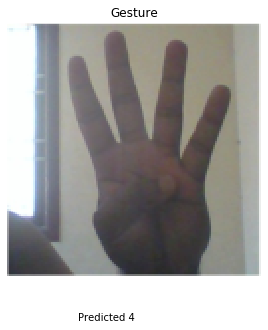

In [15]:
i = np.random.randint(100)
show_img_prediction(i, test_dataset, device)

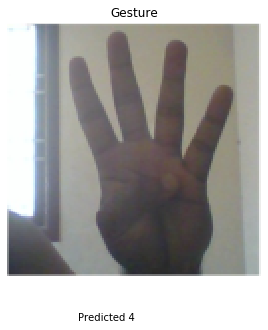

In [16]:
i = np.random.randint(100)
show_img_prediction(i, test_dataset, device)

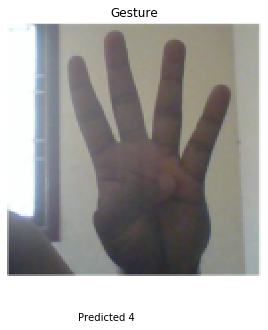

In [17]:
i = np.random.randint(100)
show_img_prediction(i, test_dataset, device)

[96.3, 95.66]


(80, 100)

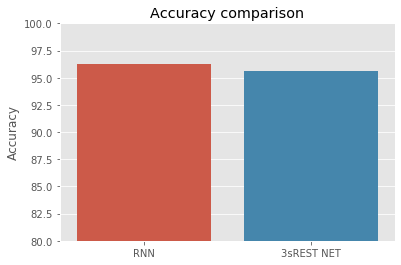

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
import math
x=['Pixel counting Algorithm','Object counting algorithm']
a=[]


a.append(ac[1])
a.append(ac[0])
print(a)
y=ac
ax=sns.barplot(x,y)
ax.set_title('Accuracy comparison')
ax.set_ylabel('Accuracy')

low = min(y)
high = max(y)
ax.set_ylim(80,100)